In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import LambdaCDM as LCDM
from MyToolkit import *
from Clustering_module import *
import numpy.ma as ma

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

In [2]:
cosmo = LCDM(H0=71, Om0=0.26, Ode0=0.74, Ob0=0.0435)

In [3]:
cosmo.comoving_distance(3.5) - cosmo.comoving_distance(2.9)

<Quantity 568.08606319 Mpc>

In [4]:
schind_23_file_name = DP2_DIRECTORY + "Data/apjaca7cat7_ascii.txt"
schind_23_data = open(schind_23_file_name, 'r')
ra_col_schind_23 = []
dec_col_schind_23 = []
red_col_schind_23 = []

skip_rows = 6
for line in schind_23_data:
    if (skip_rows > 0):
        skip_rows -= 1
        continue
    split_line = line.split()
    quasar_name = split_line[0] 
    red_col_schind_23.append(float(split_line[2]))
    ra_col_schind_23.append(float(quasar_name[4:13]))
    dec_col_schind_23.append(float(quasar_name[13:21]))
    
ra_col_schind_23 = np.array(ra_col_schind_23)
dec_col_schind_23 = np.array(dec_col_schind_23)
red_col_schind_23 = np.array(red_col_schind_23)
    

### Final function to find the $w_p(r_p)$ by only binning quasars on $r_p$. 
`find_wp_rp_single_bin(ra_column, dec_column, redshift_column, file_name_to_write_wp)`

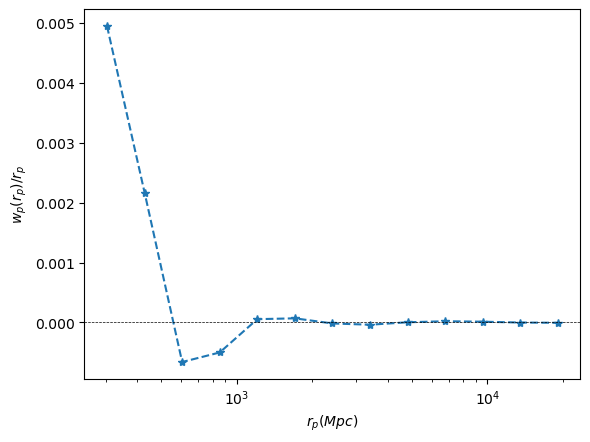

In [5]:
ax = find_wp_rp_single_bin(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, "projected_corr_table_real_signal")
ax.set_xscale('log')

### $\pi$ vs $r_p$ for the real quasar sample

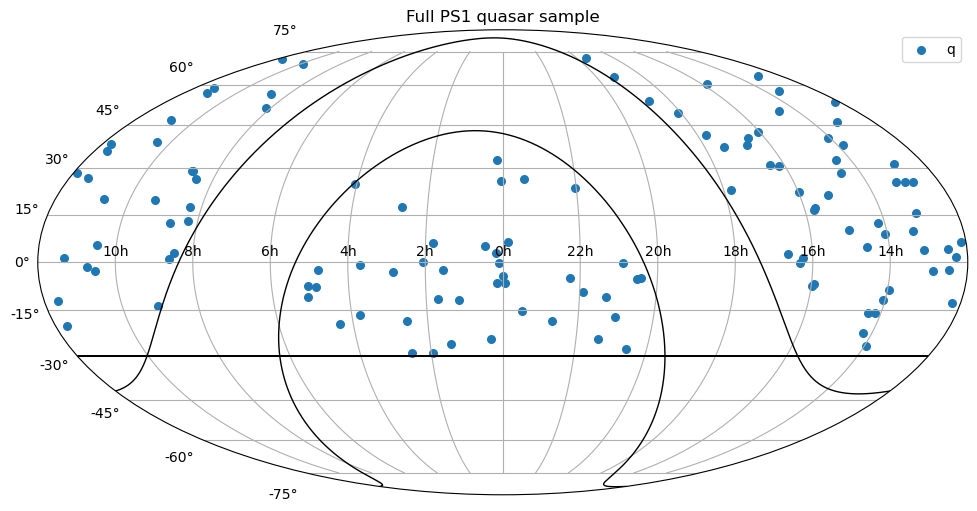

<MollweideAxes: title={'center': 'Full PS1 quasar sample'}>

In [6]:
plot_sky_map_ps1(ra_col_schind_23, dec_col_schind_23,labels = 'quasars', title="Full PS1 quasar sample")

Text(0, 0.5, '$r_p$')

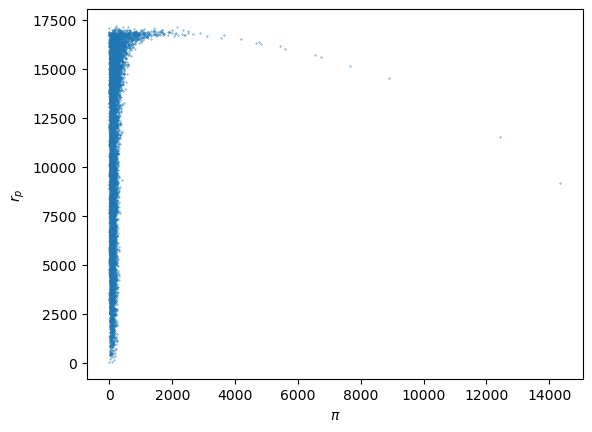

In [7]:
pi_array, rp_array = find_pi_rp(ra_col_schind_23, dec_col_schind_23, red_col_schind_23)

plt.scatter(pi_array, rp_array, s = 0.1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")

### Now we try to make a random catalog

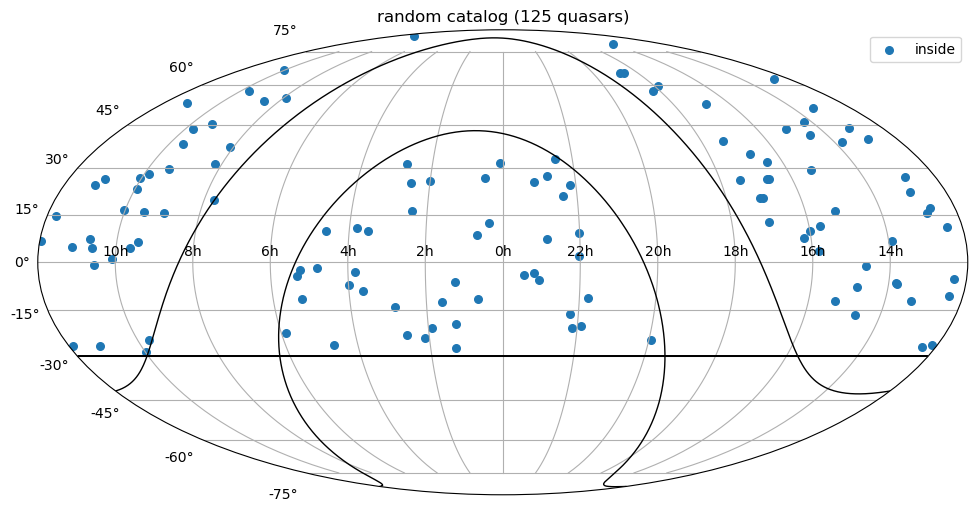

<MollweideAxes: title={'center': 'random catalog (125 quasars)'}>

In [8]:
rand_ra, rand_dec, rand_red = make_rand_cat(len(ra_col_schind_23))

# rand_mask = np.zeros_like(rand_ra, dtype='int')
# rand_mask[ind] = 1
# rand_mask = np.insert(rand_mask, 0 , 2)
plot_sky_map_ps1(rand_ra, rand_dec, labels=['inside', 'outside'], title = "random catalog (125 quasars)")

Text(0, 0.5, '$r_p$')

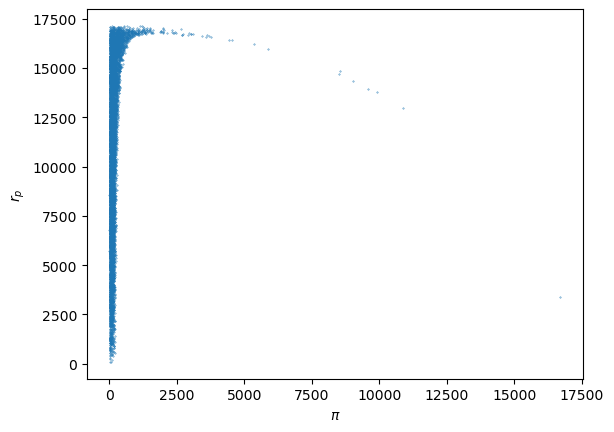

In [9]:
rand_pi_array, rand_rp_array = find_pi_rp(rand_ra, rand_dec, rand_red)

plt.scatter(rand_pi_array, rand_rp_array, s = 0.1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")

### We will find the cross catalogue $r_p$ and $\pi$

Text(0, 0.5, '$r_p$')

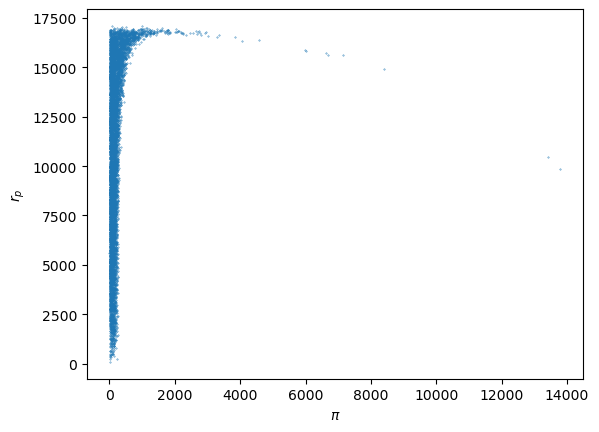

In [10]:
cross_pi_array, cross_rp_array = find_pi_rp(ra_col_schind_23, dec_col_schind_23, red_col_schind_23,\
                                             rand_ra_col = rand_ra, rand_dec_col = rand_dec, rand_red_col = rand_red)

plt.scatter(cross_pi_array, cross_rp_array, s = 0.1)
#plt.xlim(0, 10000)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")


### Here we try to implement the landy szalay estimator using the $r_p$ and $\pi$

#### $w_p$ calculated from considering the pairs only in $r_p$ bin

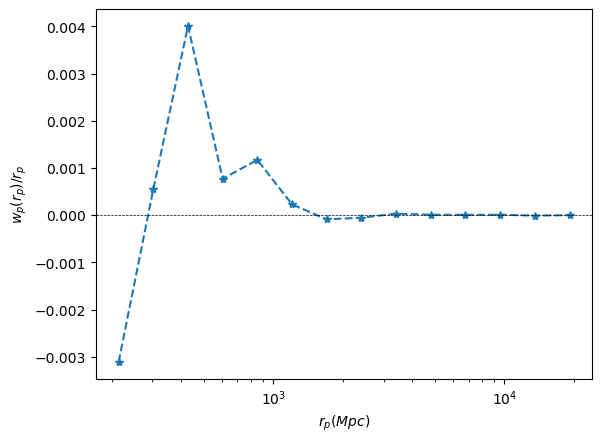

In [11]:
ax = find_wp_rp_single_bin(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, "projected_corr_table_real_signal")
ax.set_xscale('log')

#### $w_p$ of a random distribution calculated from considering the pairs only in $r_p$ bin.

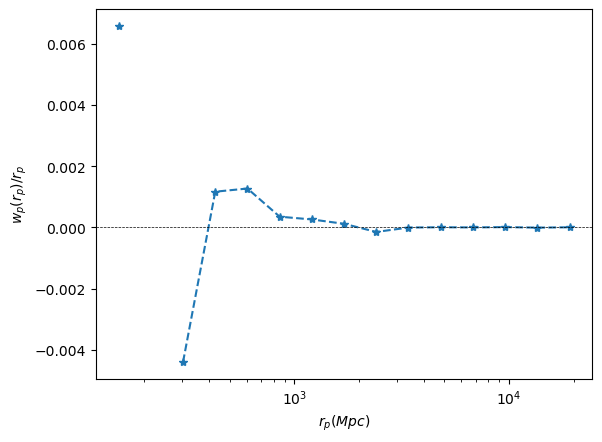

In [12]:
rand_ra2, rand_dec2, rand_red2 = make_rand_cat(125)
ax = find_wp_rp_single_bin(rand_ra2, rand_dec2, rand_red2, "projected_corr_table_rand_signal")
ax.set_xscale('log')

#### $w_p$ of a random distribution of large size

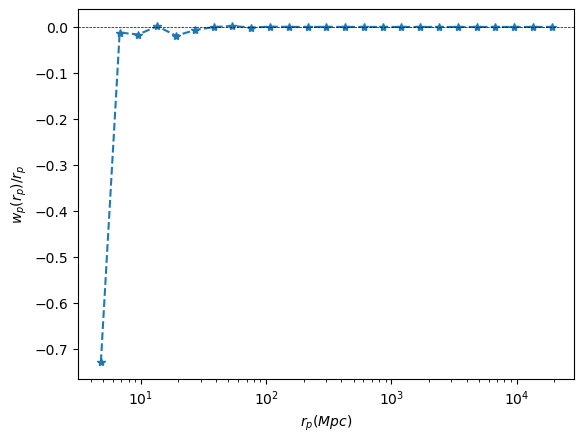

In [13]:
rand_ra2, rand_dec2, rand_red2 = make_rand_cat(10000)
ax1 = find_wp_rp_single_bin(rand_ra2, rand_dec2, rand_red2, "projected_corr_table_rand_signal")
ax1.set_xscale('log')

### Redshift space correlation function $\xi(s)$

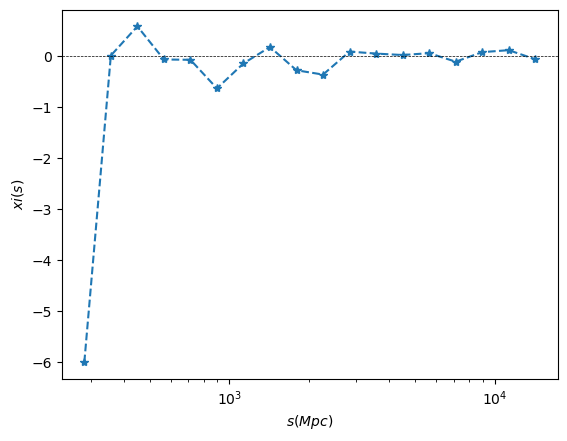

In [14]:
ax = find_xi_s(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, "redshift_space_corr_table_real_signal")
ax.set_xscale('log')

#### $\xi(r_p, \pi)$ calculated from $r_p$ and $\pi$ bins

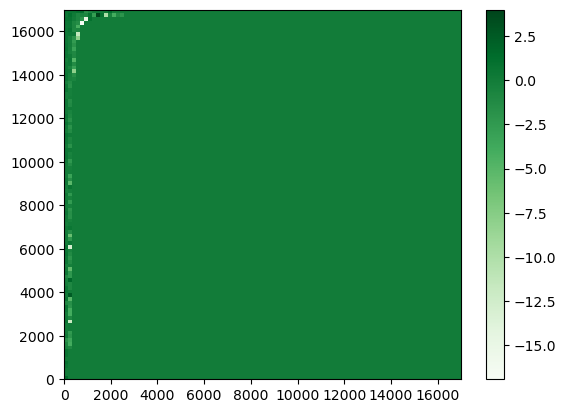

In [15]:
### making the bins of r_p and pi
Max_dist = 2 * Distance(z=6.2).value

pi_bins = np.linspace(0, 17000, 100)
#rp_bins = np.float_power(10, np.arange(34) * 0.15)
rp_bins = np.linspace(0, 17000, 100)

### counting the number of pairs in each bin
pi_rp_hist = plt.hist2d(pi_array, rp_array, [pi_bins, rp_bins])[0];
rand_pi_rp_hist = plt.hist2d(rand_pi_array, rand_rp_array, [pi_bins, rp_bins])[0];
cross_pi_rp_hist = plt.hist2d(cross_pi_array, cross_rp_array, [pi_bins, rp_bins])[0];
#plt.close()

### Normalising the number of pairs in each bin
### by deviding by the total number of pairs
pi_rp_hist = pi_rp_hist/np.sum(pi_rp_hist)
rand_pi_rp_hist = rand_pi_rp_hist/np.sum(rand_pi_rp_hist)
cross_pi_rp_hist = cross_pi_rp_hist/np.sum(cross_pi_rp_hist)

fin_pos = np.nonzero(pi_rp_hist * rand_pi_rp_hist * cross_pi_rp_hist)
unfin_pos = np.where((pi_rp_hist * rand_pi_rp_hist * cross_pi_rp_hist) == 0)

with np.errstate(divide='ignore', invalid='ignore'):
    xi_pi_rp = (pi_rp_hist + rand_pi_rp_hist - 2 * cross_pi_rp_hist)/rand_pi_rp_hist
xi_pi_rp[unfin_pos] = 0
xi_pi_rp

mesh_rp_bins, mesh_pi_bins = np.meshgrid(pi_bins, rp_bins)

c = plt.pcolormesh(mesh_pi_bins, mesh_rp_bins, xi_pi_rp, cmap = 'Greens')
plt.colorbar(c)

### Here we are demonstrating that the shape of $r_p$ vs $\pi$ graph is correct, by choosing a random distribution of objects in a 2d ring and calculating their $r_p$ and $\pi$.

In [16]:
def pi_fun(r1, r2, theta1, theta2):
    num = r2**2 - r1**2
    dinom = np.sqrt(r1**2 + r2**2 + 2 * r1 * r2 * np.cos(theta1 - theta2))
    return num/dinom

def rp_fun(r1, r2, theta1, theta2):
    num = r1**2 * r2**2 * (np.sin(theta1 - theta2))**2
    dinom = r1**2 + r2**2 + 2 * r1 * r2 * np.cos(theta1 - theta2)
    return 2 * np.sqrt(num/dinom)

In [17]:
r1 = 10000 + 10 * np.random.rand(1000)
r2, r1 = np.meshgrid(r1, r1)
theta1 = 2*np.pi * np.random.rand(1000)
theta2, theta1 = np.meshgrid(theta1, theta1)

v_pi_fun = np.vectorize(pi_fun)
v_rp_fun = np.vectorize(rp_fun)

pi_plot_array = np.absolute(pi_fun(r1, r2, theta1, theta2))
rp_plot_array = rp_fun(r1, r2, theta1, theta2)

pi_plot_array = pi_plot_array[np.triu_indices(len(pi_plot_array),k = 1)]
rp_plot_array = rp_plot_array[np.triu_indices(len(rp_plot_array),k = 1)]

Text(0, 0.5, '$r_p$')

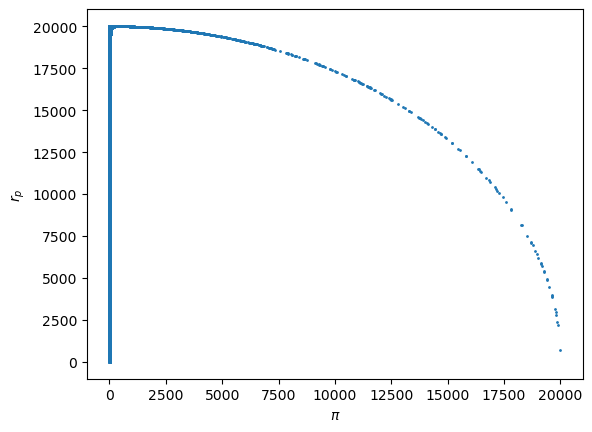

In [18]:
plt.scatter(pi_plot_array, rp_plot_array, s = 1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")